In [2]:
from tsmc.processing import calculate_transition_matrix
from tsmc.config import population_time_interval
from tsmc.config import population_times
population_time = population_times('arabidopsis_methyl')
population_times = population_time_interval(delta=0.001, K=42, tmax=2_100_100).tolist()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.patches import Rectangle
import msprime



def create_sawtooth_demogaphy_object(Ne = 10**4, magnitue=2):
    demography = msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None,growth_rate=6437.7516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0,initial_size=Ne)
    return demography

import msprime
import numpy as np
from scipy.interpolate import interp1d


def interpolate_tmrca_per_window(position, tmrca, interval_start = 0, interval_end = 500_000, interval_size = 2000):
    """ Calculates sum tmrca estimate, when given the position and the tmrca """
    x_points = position
    y_points = tmrca
    interp_function = interp1d(x_points, y_points, kind='previous', fill_value="extrapolate")
    intervals = np.arange(interval_start, interval_end, interval_size)
    averages = []
    for i in range(len(intervals)-1):
        start = intervals[i] 
        end = intervals[i + 1]
        x_vals = np.linspace(start, end, 100)  # More points for better accuracy
        y_vals = interp_function(x_vals)
        average = np.mean(y_vals)
        averages.append(average)
    return np.array(averages)

def get_interpolated_tmrca_landscape(ts, window_size):

    tmrca_landscape = []
    for tree in ts.trees():
        left = tree.interval.left
        right = tree.interval.right
        node = [node for node in tree.nodes() if node not in [0, 1]][0]
        tmrca = tree.time(node)
        tmrca_landscape.append((left, right, node, tmrca))
    tmrca_landscape = np.array(tmrca_landscape)

    y_tmrca_interpolated = interpolate_tmrca_per_window(
        tmrca_landscape[:, 0],
        tmrca_landscape[:, 3], interval_end=int(ts.sequence_length)+window_size, interval_size=window_size
    )

    return y_tmrca_interpolated







Site introduction rate: 1e-06
Methylation rate: 1e-06
De-Methylation rate: 2.4999999999999998e-06
Methylation probability: 0.28571428571428575
De-Methylation probability: 0.7142857142857143
Transition matrix:
[[0.7142857142857142, 0.28571428571428575], [0.7142857142857143, 0.2857142857142857]]


KeyboardInterrupt: 

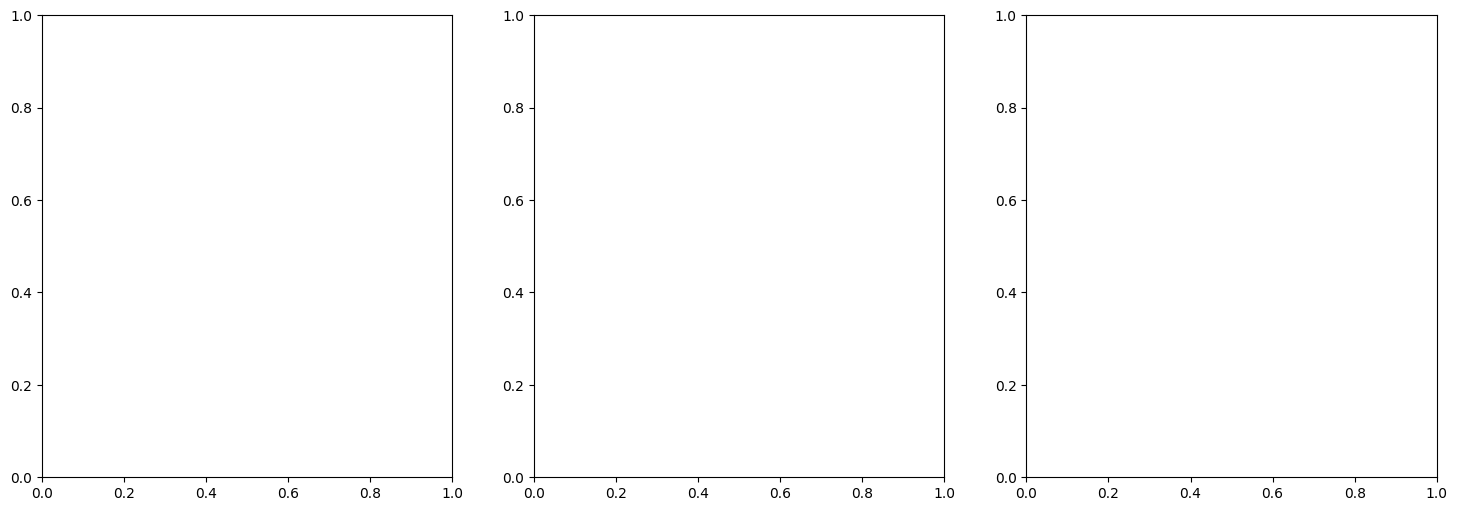

In [3]:

def get_counts_tmrcas(site_introduction_rate, methylation_factor, demethylation_factor):
    methylation_rate = methylation_factor * site_introduction_rate
    demethylation_rate = demethylation_factor * site_introduction_rate
    
    # Calculate probabilities
    methylation_probability = methylation_rate / (methylation_rate + demethylation_rate)
    demethylation_probability = demethylation_rate / (methylation_rate + demethylation_rate)
    
    print(f"Site introduction rate: {site_introduction_rate}")
    print(f"Methylation rate: {methylation_rate}")
    print(f"De-Methylation rate: {demethylation_rate}")
    print(f"Methylation probability: {methylation_probability}")
    print(f"De-Methylation probability: {demethylation_probability}")
    
    alleles = ["0", "1"]
    transition_matrix = [
        [1 - methylation_probability, methylation_probability],
        [demethylation_probability, 1 - demethylation_probability]
    ]
    print("Transition matrix:")
    print(transition_matrix)
    
    methylation_model = msprime.MatrixMutationModel(
        alleles,
        root_distribution=[0.5, 0.5],
        transition_matrix=transition_matrix
    )
    
    demography_object = create_sawtooth_demogaphy_object(Ne=2*10**5, magnitue=8)
    ts = msprime.sim_ancestry(
        2,
        demography=demography_object,
        random_seed=142,
        sequence_length=5_000_000,
        ploidy=1,
        recombination_rate=3.4e-8
    )
    ts = msprime.sim_mutations(ts, rate=site_introduction_rate, random_seed=42, model=methylation_model, discrete_genome=True)
    
    variants = []
    for v in ts.variants():
        variants.append([int(v.alleles[k]) for k in v.genotypes])
    variants = np.array(variants)
    gm = variants.T
    invariant_mask = np.logical_or(gm.sum(0) == 0, gm.sum(0) == ts.num_samples)
    gm = gm[:, ~invariant_mask]
    positions = np.array([v.position for i, v in enumerate(ts.variants())])
    positions = positions[~invariant_mask]
    
    window_size = 1000
    binary_ts = ts.simplify(samples=[0, 1])
    tmrcas = get_interpolated_tmrca_landscape(binary_ts, window_size=window_size)
    
    gm_pivot = gm[[0, 1]]
    gm_pivot_xored = gm_pivot[0] ^ gm_pivot[1]
    positions_pivot = positions[gm_pivot_xored == 1]
    data = positions_pivot
    
    num_windows = (int(ts.sequence_length) // window_size)
    counts = np.zeros(num_windows, dtype=int)
    indices = (data // window_size).astype(int)
    np.add.at(counts, indices, 1)
    
    debugger = msprime.DemographyDebugger(demography=demography_object)
    population_size = debugger.population_size_trajectory(population_time).flatten()
    
    print(f"Variants shape before filtering: {variants.shape[0]}")
    print(f"Genotype matrix shape after filtering: {gm.shape[1]}")
    
    return counts, tmrcas

def plot_methylation_figure(counts, tmrcas, ax, site_introduction_rate, methylation_rate, demethylation_rate, hlines):
    log_counts = np.log(1+counts)
    log_tmrcas = np.log(1+tmrcas)
    
    ax.plot([0, 13.5], [0, 13.5])
    sns.set_style("ticks")
    
    hexbin = ax.hexbin(log_counts, log_tmrcas, gridsize=50, cmap='viridis',
                       mincnt=1, bins='log')
    ax.set_xlabel('Log(#Marker)', fontsize=14)
    ax.set_ylabel('Log(TMRCAs)', fontsize=14)
    ax.tick_params(labelsize=16)
    
    def format_rate(rate):
        exponent = int(np.floor(np.log10(abs(rate))))
        mantissa = rate / 10**exponent
        return f"${mantissa:.2f} \\times 10^{{{exponent}}}$"
    
    rates_text = (
        f"Marker-Rate:\n{(format_rate(site_introduction_rate))}\n"
        f"Methylation-Rates:\n"
        f"U → M: {format_rate(methylation_rate)}\n"
        f"M → U: {format_rate(demethylation_rate)}\n"
    )
    ax.text(0.975, 0.025, rates_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    ax.grid(True)
    ax.set_xlim([0, 13.5])
    ax.set_ylim([1, 13.5])
    
    for hline in hlines:
        ax.axhline(hline, c="black", linestyle="--", alpha=0.25)
    
    return hexbin

# Set up the main figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Generate data for all three scenarios
scenarios = [
    (1e-6 * 1, 1, 2.5),
    (1e-6 * 10, 1, 2.5),
    (1e-6 * 100, 1, 2.5)
]

# Define horizontal lines for each figure
hlines = [
    [13, 7.5],  # for the first figure
    [10, 6.5],  # for the second figure
    [8.5, 6.5]  # for the third figure
]

hexbins = []

# Plot figures
axes = [ax1, ax2, ax3]
titles = ["A)", "B)", "C)"]
for i, ((site_rate, meth_factor, demeth_factor), ax, title, hline) in enumerate(zip(scenarios, axes, titles, hlines)):
    counts, tmrcas = get_counts_tmrcas(site_rate, meth_factor, demeth_factor)
    methylation_rate = meth_factor * site_rate
    demethylation_rate = demeth_factor * site_rate
    hexbin = plot_methylation_figure(counts, tmrcas, ax, site_rate, methylation_rate, demethylation_rate, hline)
    hexbins.append(hexbin)
    ax.set_title(title, loc="left", fontsize=16)

# Find global min and max
vmin = min(hb.get_array().min() for hb in hexbins)
vmax = max(hb.get_array().max() for hb in hexbins)

# Set consistent color limits for all hexbin plots
for hb in hexbins:
    hb.set_clim(vmin, vmax)

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(hexbins[-1], cax=cbar_ax)
cbar.set_label('Count in bin (log scale)', fontsize=18)
cbar.ax.tick_params(labelsize=18)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])
#plt.savefig("meth-sim25.pdf", dpi=400, bbox_inches='tight')
plt.show()